# Code #

### Basic Preprocessing ###

The texts were found in various places on the internet. Many were found on Project Gutenberg. I remove boilerplate Project Gutenberg matter and eliminate non-alphabetic characters with the code in the following cell. Further lemmatization is performed later. The code runs on all the files found in a user specified directory. The resulting files should be zipped together before being fed to the word2vec implementation.

In [1]:
%%writefile basic_preprocessing.py
#This code removes boilerplate "Project Gutenberg" material from text document as well as non-alphabetical characters

dirr = "C:/Users/Reid/Dropbox/MIDS/266/texts" #modify this to whatever directory holds the files

import os
fileList = os.listdir(dirr)

from nltk.tokenize import RegexpTokenizer

#Loop over files in directory
for inputFile in fileList:
    if '.txt' not in inputFile:
        continue

    with open(dirr+'/'+inputFile,'rb') as f:
        wordList = f.read()

    a = wordList.split('*** START OF THIS PROJECT GUTENBERG EBOOK')

    print inputFile
    if len(a) > 1:
        print len(a)
        wordList = a[1]
        a = wordList.split('End of the Project Gutenberg EBook of')
        print len(a)
        if len(a) > 1:
            wordList = a[0]

    tokenizer = RegexpTokenizer(r'[a-zA-Z_]+')
    document_token = tokenizer.tokenize(wordList)

    document_token = [x.lower() for x in document_token]

    print document_token[:10]

    c = 'abcdefghijklmnopqrstuvwxyz_'

    if sum([sum([x in c for x in word]) - len(word) for word in document_token]) != 0:
        for word in document_token:
            if sum([x in c for x in word]) - len(word) != 0:
                print word
        print 'wrong'
        break

    document_string = ' '.join(document_token)
    with open(dirr+'/token/'+inputFile[:-4]+'_token.txt','w') as f:
        f.write(document_string)

Overwriting basic_preprocessing.py


## Code assumes the following files are available: ##
    GoogleNews-vectors-negative300.bin - pretrained word embeddings
    token_tag.zip - preprocessed versions all works considered in this study
    bud.zip - preprocessed collection of Buddhist documents
    chi.zip - preprocessed collection of Chinese documents
    chr.zip - preprocessed collection of Christian documents
    hin.zip - preprocessed collection of Hindu documents
    jud.zip - preprocessed collection of Judaic documents
    mus.zip - preprocessed collection of Muslim documents

### List of Interesting Words ###

In [2]:
word_list = [\
             'good',\
             'bad',\
             'heaven',\
             'hell',\
             'man',\
             'king',\
             'evil',\
             'holy',\
             'peace',\
             'salvation',\
             'eternal',\
             'time',\
             'destroy',\
             'pray',\
             'god',\
             'faith',\
             'death',\
             'birth',\
             'life',\
             'war',\
             'child',\
             'sin',\
             'body',\
             'mercy',\
             'love',\
             'hate',\
             'soul',\
             'justice',\
             'joy',\
             'suffer',\
             'wisdom',\
             'worship',\
             'truth',\
             'knowledge',\
             'friend',\
             'friendship',\
             'desire',\
             'suffering',\
             'happy',\
             'happiness',\
             'rejoice',\
            ]

## Word2Vec Implementation - and acknowledgement ##

This code is largely built on the basic word2vec code provided by tensorflow. I have modularized it for ease of use and have modified it to fit the purposes of this project - including creating and processing corpora and analyzing a user specified list of words. 

The original tensorflow code is found here:  
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py


### Set up environment ###

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from nltk.stem.snowball import EnglishStemmer
snowball_stemmer = EnglishStemmer()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import pickle
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

### Create Corpus Function###

In [4]:
def read_data(filename):
  """Extract the files enclosed in a zip file as a list of words"""
  data = []
  with zipfile.ZipFile(filename) as f:
        for current_file in f.namelist():
            print (current_file)
            datanew=tf.compat.as_str(f.read(current_file)).split()
            print ("Raw data length: ", len(datanew))
            datanew_processed = [wnl.lemmatize(x) for x in datanew]
            #datanew_processed = [snowball_stemmer.stem(x) for x in datanew]
            data = data + datanew_processed
  return data

### Create Dictionaries Function###

In [5]:
def build_dataset(words, vocabulary_size):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary


### Batch Generation Function ###

In [6]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

### Load Pretrained Embedding###

In [7]:
def load_bin_vec(fname): 
    """ 
    Loads 300x1 word vecs from Google (Mikolov) word2vec 
    """ 
    word_vecs = {} 
    with open(fname, "rb") as f: 
        header = f.readline() 
        vocab_size, layer1_size = map(int, header.split()) 
        binary_len = np.dtype('float32').itemsize * layer1_size 
        for line in xrange(vocab_size): 
            word = [] 
            while True: 
                ch = f.read(1) 
                if ch == ' ': 
                    word = ''.join(word) 
                    break 
                if ch != '\n': 
                    word.append(ch)   
            word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')   
    return word_vecs

### Word2Vec ###

In [8]:
def run_word2vec(dictionary, reverse_dictionary, batch_size=128,num_skips=2,skip_window=1,embedding_size = 128):

    #valid_examples = [dictionary[snowball_stemmer.stem(x)] for x in word_list]
    valid_examples = [dictionary[wnl.lemmatize(x)] for x in word_list]
    valid_size = len(valid_examples)
    embedding_dict = load_bin_vec('GoogleNews-vectors-negative300.bin')
    lemma_dict = {}
    import string
    printable = set(string.printable)
    for word in embedding_dict.keys():
        word_stripped = ''.join(filter(lambda x: x in string.printable, word))
        lemma_dict[wnl.lemmatize(word_stripped)] = embedding_dict[word]
    embedding_small_dict = {}
    for word in dictionary.keys():
        if word in lemma_dict.keys():
            if word in word_list:
                embedding_small_dict[word] = np.random.uniform(-1,1,embedding_size)
            else:
                embedding_small_dict[word] = lemma_dict[word]
        else:
            embedding_small_dict[word] = np.random.uniform(-1,1,embedding_size)
    embedding = np.array(embedding_small_dict.values())
    embedding_labels = np.array(embedding_small_dict.keys())

    num_sampled = 64    # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default():

      # Input data.
      train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
      train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
      valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Ops and variables pinned to the CPU because of missing GPU implementation
      with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        #embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embeddings = tf.get_variable("embeddings", shape=[len(embedding_small_dict.values()), embedding_size], initializer=tf.constant_initializer(embedding))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

      # Compute the average NCE loss for the batch.
      # tf.nce_loss automatically draws a new sample of the negative labels each
      # time we evaluate the loss.
      loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

      # Construct the SGD optimizer using a learning rate of 1.0.
      optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

      # Compute the cosine similarity between minibatch examples and all embeddings.
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
      similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)

      # Add variable initializer.
      init = tf.global_variables_initializer()

    #Begin training.
    num_steps = 100001
    #num_steps = 1

    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
      init.run()
      print("Initialized")

      average_loss = 0
      for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print("Average loss at step ", step, ": ", average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 5  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            #print (nearest)
            log_str = "Nearest to %s:" % valid_word
            for k in xrange(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log_str = "%s %s," % (log_str, close_word)
            print(log_str)
      final_embeddings = normalized_embeddings.eval()
    return final_embeddings

### Plot Generation Function###

In [9]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

### Launcher Function ###

In [10]:
def run_all(filename):
    stripped_filename = filename[:-4]
    words = read_data(filename)
    print('Data size', len(words))
    global vocabulary_size
    vocabulary_size = int(len(set(words))*0.4)
    print('Vocabulary Size: ', vocabulary_size)
    
    global data

    data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
    del words  # Hint to reduce memory.
    print('Most common words (+UNK)', count[:5])
    print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

    global data_index
    data_index = 0

    batch_size = 128
    embedding_size = 300  # Dimension of the embedding vector.
    skip_window = 6       # How many words to consider left and right.
    num_skips = 2         # How many times to reuse an input to generate a label.


    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    for i in range(8):
      print(batch[i], reverse_dictionary[batch[i]],
            '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

    final_embeddings = run_word2vec(dictionary = dictionary, reverse_dictionary = reverse_dictionary,batch_size=batch_size,num_skips=num_skips,skip_window=skip_window,embedding_size = embedding_size)

    try:
      tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
      plot_only = 500
      low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
      labels = [reverse_dictionary[i] for i in xrange(plot_only)]
      plot_with_labels(low_dim_embs, labels,stripped_filename)
      plt.show()

    except ImportError:
        print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")
    
    return final_embeddings, dictionary

# Let's Run It!#

## Create & Visualize Word Embeddings on Full Corpus (non-appended) ##

This creates word vectors from a corpus comprised of the documents in this study.

Vishnupurana_hin_token_hin.txt
Raw data length:  154825
writings_of_francis_of_assisi_token_chr.txt
Raw data length:  54212
95_theses_token_chr.txt
Raw data length:  4528
Al Sira al Nabawiyya By Ibn Kathir-All Volumes in One_token_mus.txt
Raw data length:  1000245
amitabha_token_bud.txt
Raw data length:  20807
ancient_jewish_proverbs_token_jud.txt
Raw data length:  24475
art_of_war_chi_token_chi.txt
Raw data length:  57591
bhagavad_gita_token_hin.txt
Raw data length:  20763
bible_token_chr.txt
Raw data length:  791844
book_of_poetry_chi_token.txt
Raw data length:  77547
chinese_buddhism_chi_token.txt
Raw data length:  163782
chinese_buddhism_token_chi.txt
Raw data length:  163782
confession_of_st_augustine_token_chr.txt
Raw data length:  112466
Confucius - Analects_token_chi.txt
Raw data length:  28097
Confucius - The Doctorine of the Mean_token_chi.txt
Raw data length:  6711
Confucius - The Great Learning_token_chi.txt
Raw data length:  3085
dao_de_jing_token_chi.txt
Raw data length: 

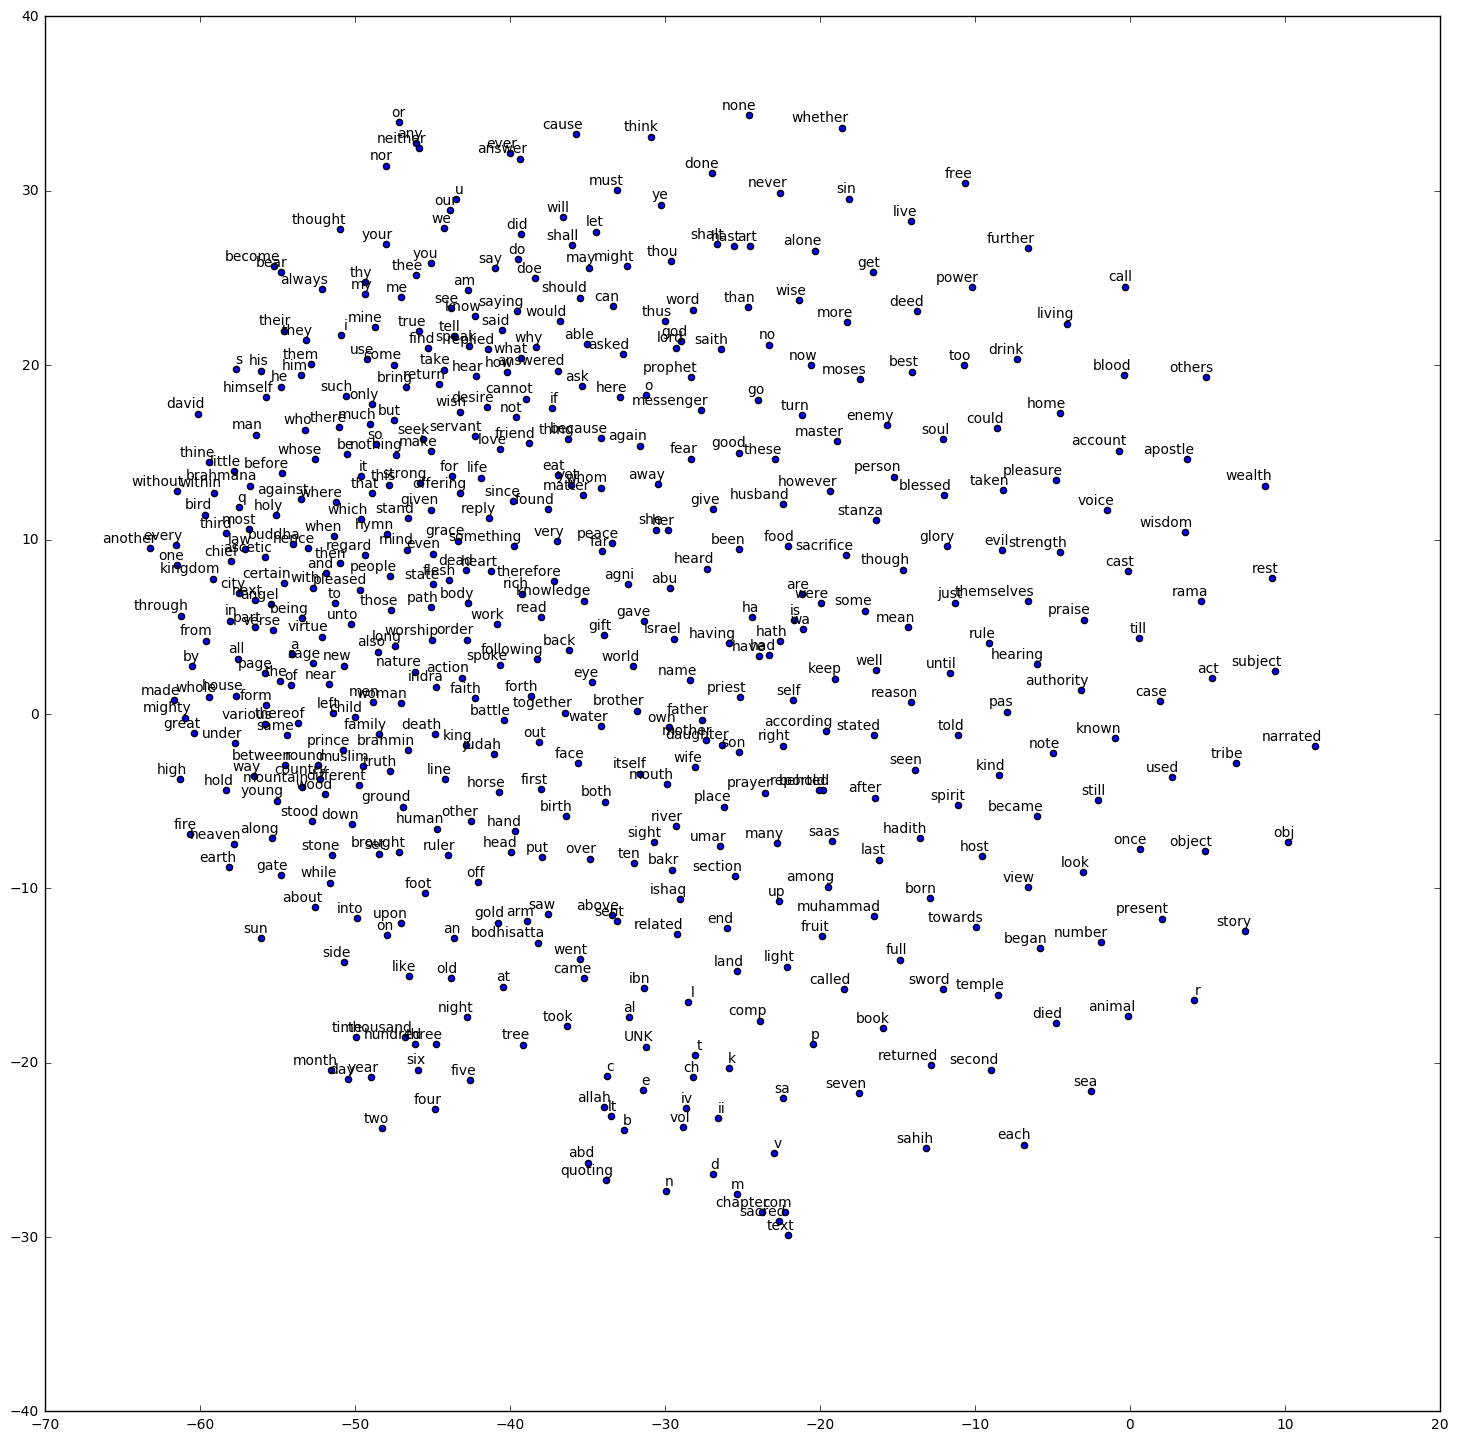

In [11]:
embeddings, dictionary = run_all('token_tag.zip')
pickle.dump(dictionary, open("large_dictionary.p", "wb" ))
pickle.dump(embeddings, open("large_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Buddhist texts ##

jataka_v4_bud_token_bud.txt
Raw data length:  151122
jataka_v5_bud_token_bud.txt
Raw data length:  140608
jataka_v6_bud_token_bud.txt
Raw data length:  165140
lotus_sutra_token_bud.txt
Raw data length:  84379
amitabha_token_bud.txt
Raw data length:  20807
Dhammapada_bud_token_bud.txt
Raw data length:  11763
Digha Nikaya_bud_token_bud.txt
Raw data length:  198019
jataka_v1_bud_token_bud.txt
Raw data length:  169221
jataka_v2_bud_token_bud.txt
Raw data length:  143457
jataka_v3_bud_token_bud.txt
Raw data length:  149213
Data size 1233729
Vocabulary Size:  9465
Most common words (+UNK) [['UNK', 22316], ('the', 87689), ('and', 49052), ('of', 33641), ('a', 33153)]
Sample data [1, 88, 231, 645, 272, 19, 526, 323, 396, 550] ['the', 'jataka', 'vol', 'iv', 'tr', 'by', 'w', 'h', 'd', 'rouse']
526 w -> 19 by
526 w -> 25 at
323 h -> 645 iv
323 h -> 200 text
396 d -> 645 iv
396 d -> 25 at
550 rouse -> 19 by
550 rouse -> 396 d
Initialized
Average loss at step  0 :  210.94178772
Nearest to good: hand

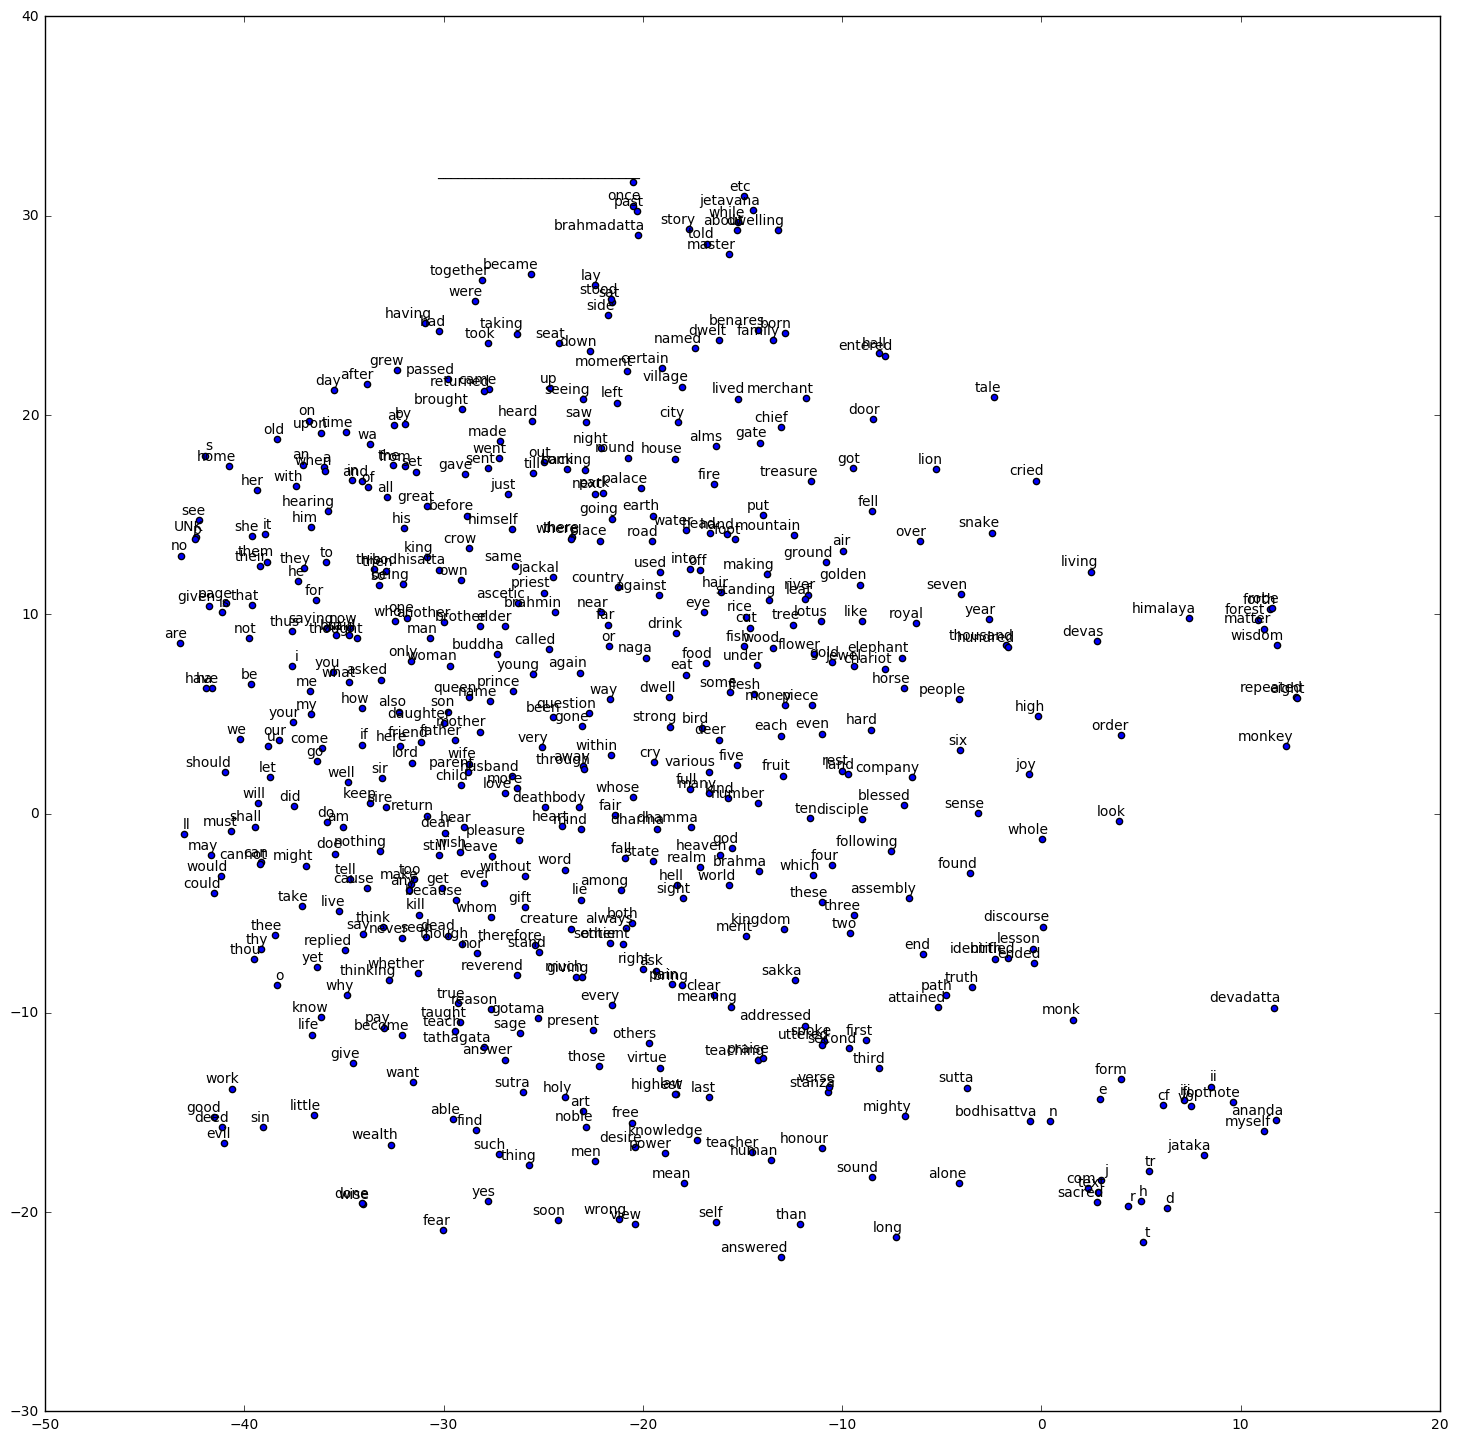

In [12]:
embeddings, dictionary = run_all('bud.zip')
pickle.dump(dictionary, open("bud_dictionary.p", "wb" ))
pickle.dump(embeddings, open("bud_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Chinese texts ##

I_Ching_chi_token_chi.txt
Raw data length:  67471
lijing_chi_token.txt
Raw data length:  281820
mencius_chi_token.txt
Raw data length:  65029
myths_legends_china_chi_token.txt
Raw data length:  138740
sacred_books_of_the_east_3_chi_token.txt
Raw data length:  156026
art_of_war_chi_token_chi.txt
Raw data length:  57591
book_of_poetry_chi_token.txt
Raw data length:  77547
chinese_buddhism_chi_token.txt
Raw data length:  163782
chinese_buddhism_token_chi.txt
Raw data length:  163782
Confucius - Analects_token_chi.txt
Raw data length:  28097
Confucius - The Doctorine of the Mean_token_chi.txt
Raw data length:  6711
Confucius - The Great Learning_token_chi.txt
Raw data length:  3085
dao_de_jing_token_chi.txt
Raw data length:  10446
Data size 1220127
Vocabulary Size:  9168
Most common words (+UNK) [['UNK', 26069], ('the', 105271), ('of', 54337), ('and', 37948), ('to', 33430)]
Sample data [64, 226, 1, 1912, 319, 64, 226, 1, 1912, 57] ['ch', 'ien', 'the', 'creative', 'above', 'ch', 'ien', 'the

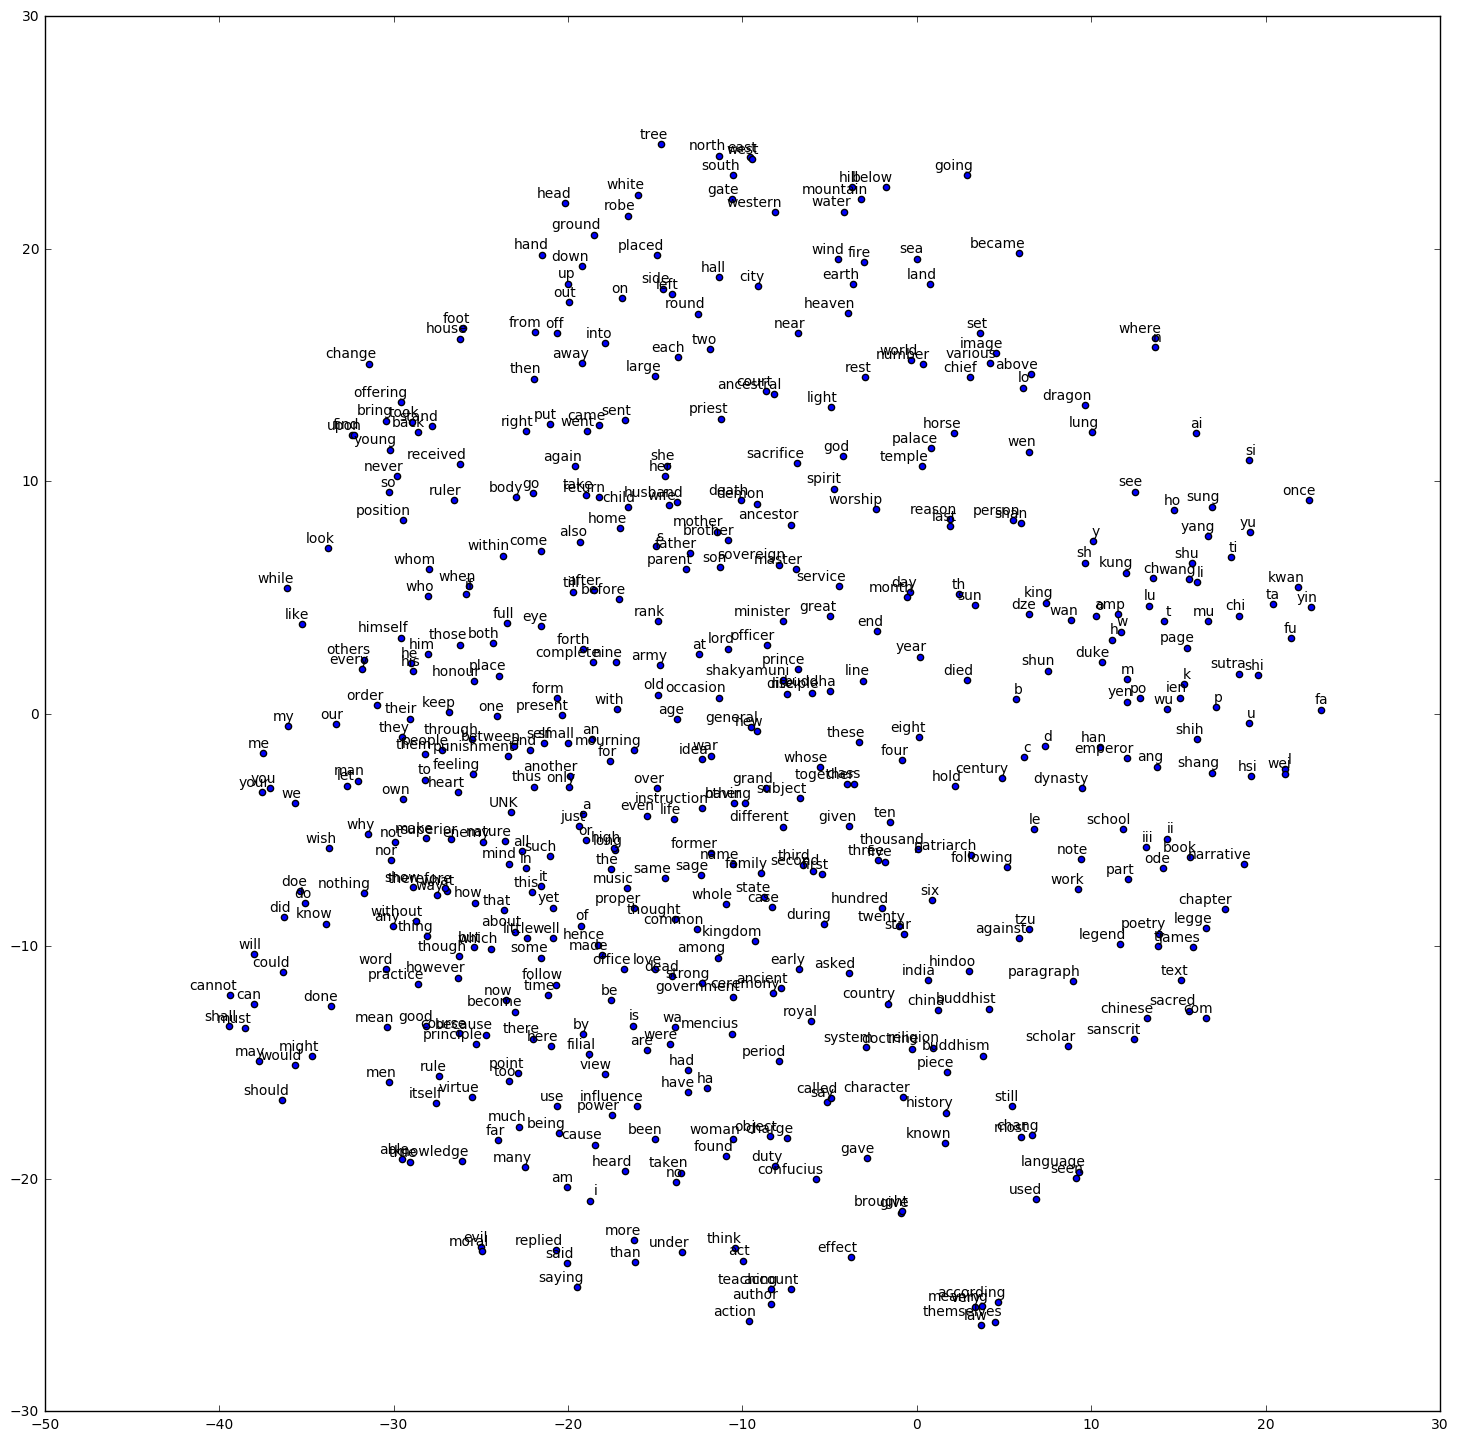

In [13]:
embeddings, dictionary = run_all('chi.zip')
pickle.dump(dictionary, open("chi_dictionary.p", "wb" ))
pickle.dump(embeddings, open("chi_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Christian texts ##

writings_of_francis_of_assisi_token_chr.txt
Raw data length:  54212
95_theses_token_chr.txt
Raw data length:  4528
bible_token_chr.txt
Raw data length:  791844
confession_of_st_augustine_token_chr.txt
Raw data length:  112466
large_catechism_chr_token_chr.txt
Raw data length:  50395
PROSLOGION_chr_token_chr.txt
Raw data length:  43722
small_catechism_chr_token_chr.txt
Raw data length:  7130
summa_theologica_token_chr.txt
Raw data length:  498192
Data size 1562489
Vocabulary Size:  8638
Most common words (+UNK) [['UNK', 21462], ('the', 113748), ('and', 72471), ('of', 64507), ('to', 36976)]
Sample data [1, 725, 3, 324, 444, 3, 1441, 2258, 25, 2413] ['the', u'writing', 'of', 'st', 'francis', 'of', 'assisi', 'tr', 'by', 'paschal']
1441 assisi -> 3 of
1441 assisi -> 1 the
2258 tr -> 1441 assisi
2258 tr -> 3 of
25 by -> 2258 tr
25 by -> 1615 sacred
2413 paschal -> 324 st
2413 paschal -> 2258 tr
Initialized
Average loss at step  0 :  194.529907227
Nearest to good: imagined, released, seem, fo

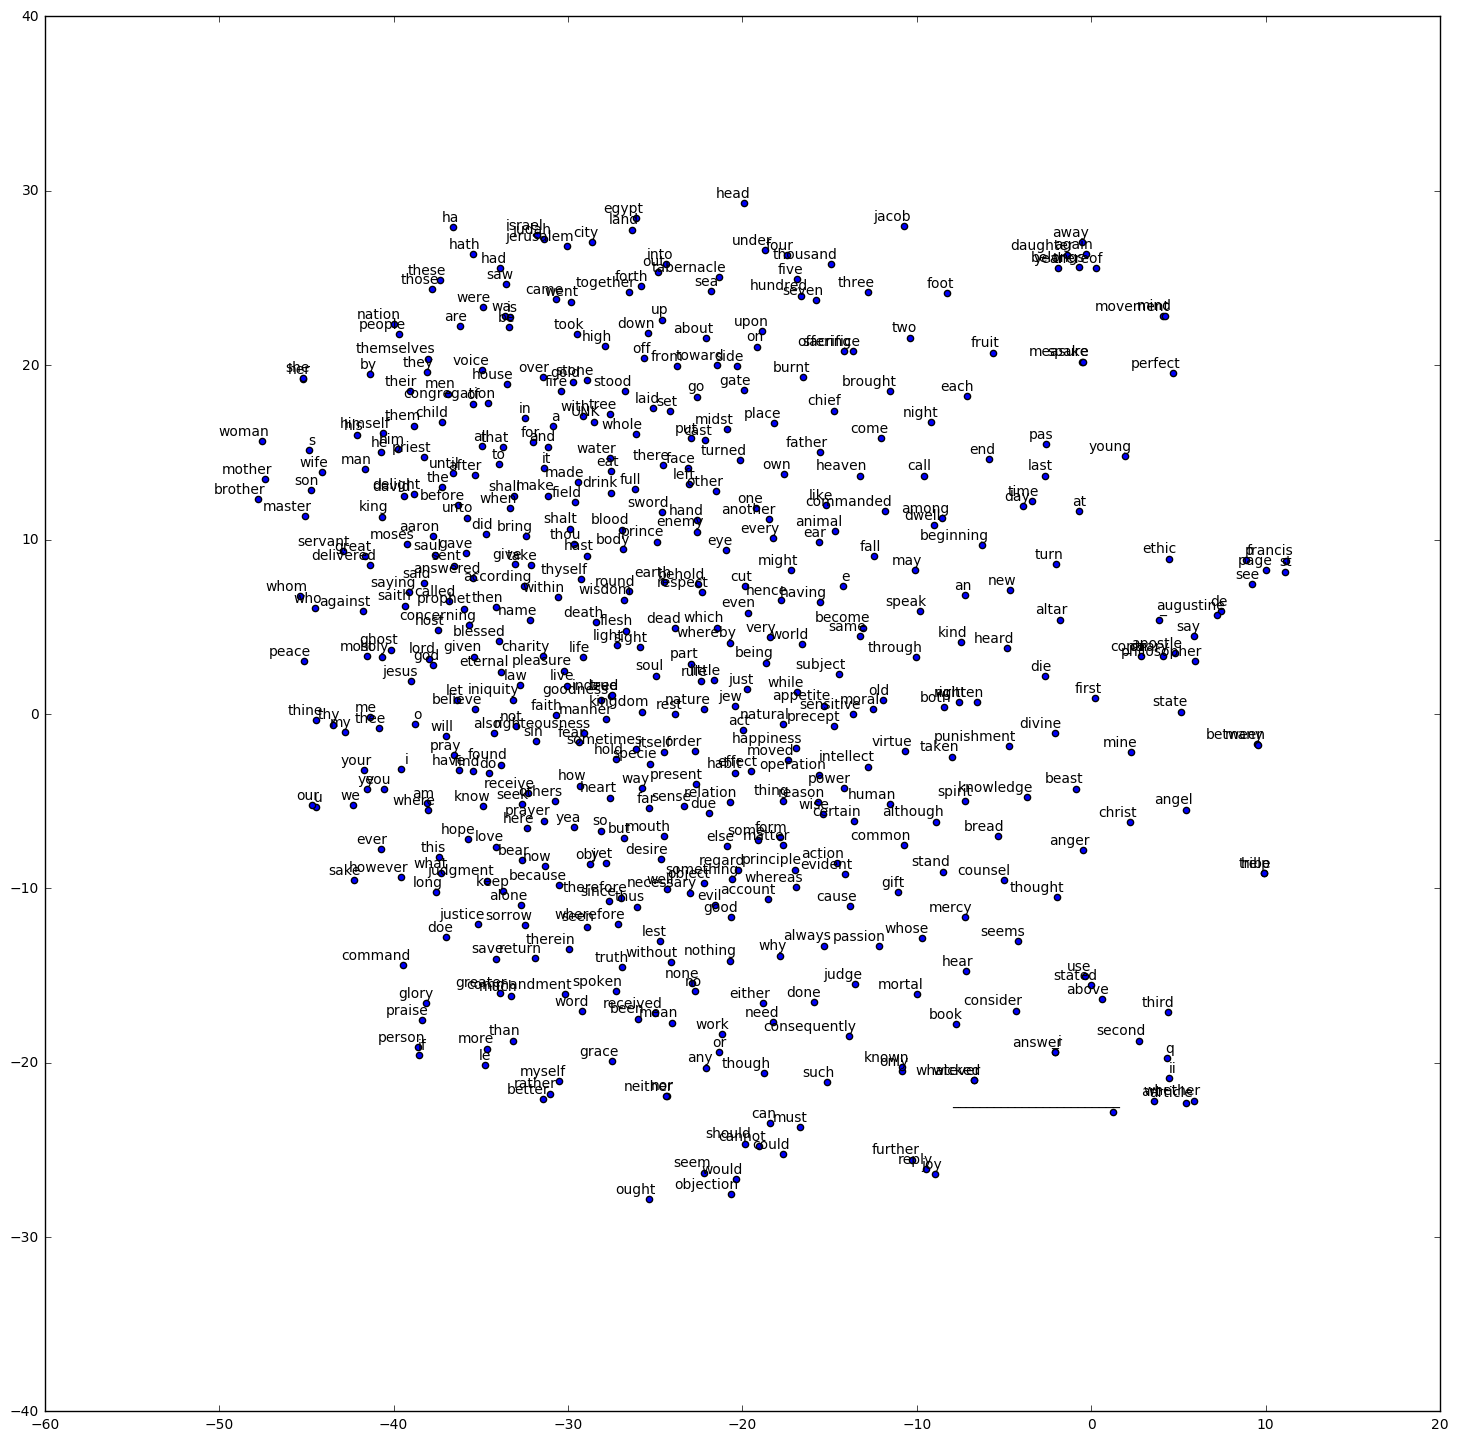

In [14]:
embeddings, dictionary = run_all('chr.zip')
pickle.dump(dictionary, open("chr_dictionary.p", "wb" ))
pickle.dump(embeddings, open("chr_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Hindu texts ##

Upanishad2_token_hin.txt
Raw data length:  93816
upanishads_token_hin.txt
Raw data length:  17827
Vishnupurana_hin_token_hin.txt
Raw data length:  154825
bhagavad_gita_token_hin.txt
Raw data length:  20763
Mahabharata_hin_token_hin.txt
Raw data length:  638954
Ramayana_hin_token_hin.txt
Raw data length:  408799
rig_veda_hin_token_hin.txt
Raw data length:  300622
Upanishad1_token_hin.txt
Raw data length:  91658
Data size 1727264
Vocabulary Size:  16802
Most common words (+UNK) [['UNK', 28687], ('the', 120540), ('and', 68826), ('of', 64690), ('to', 33447)]
Sample data [4848, 373, 175, 2866, 175, 7539, 0, 660, 3, 532] ['katha', 'upanishad', 'first', 'adhyaya', 'first', 'valli', 'UNK', 'desirous', 'of', 'heavenly']
0 UNK -> 40 at
0 UNK -> 7539 valli
660 desirous -> 7914 surrendered
660 desirous -> 1429 reward
3 of -> 7914 surrendered
3 of -> 660 desirous
532 heavenly -> 2866 adhyaya
532 heavenly -> 5 a
Initialized
Average loss at step  0 :  235.266708374
Nearest to good: kingless, producet

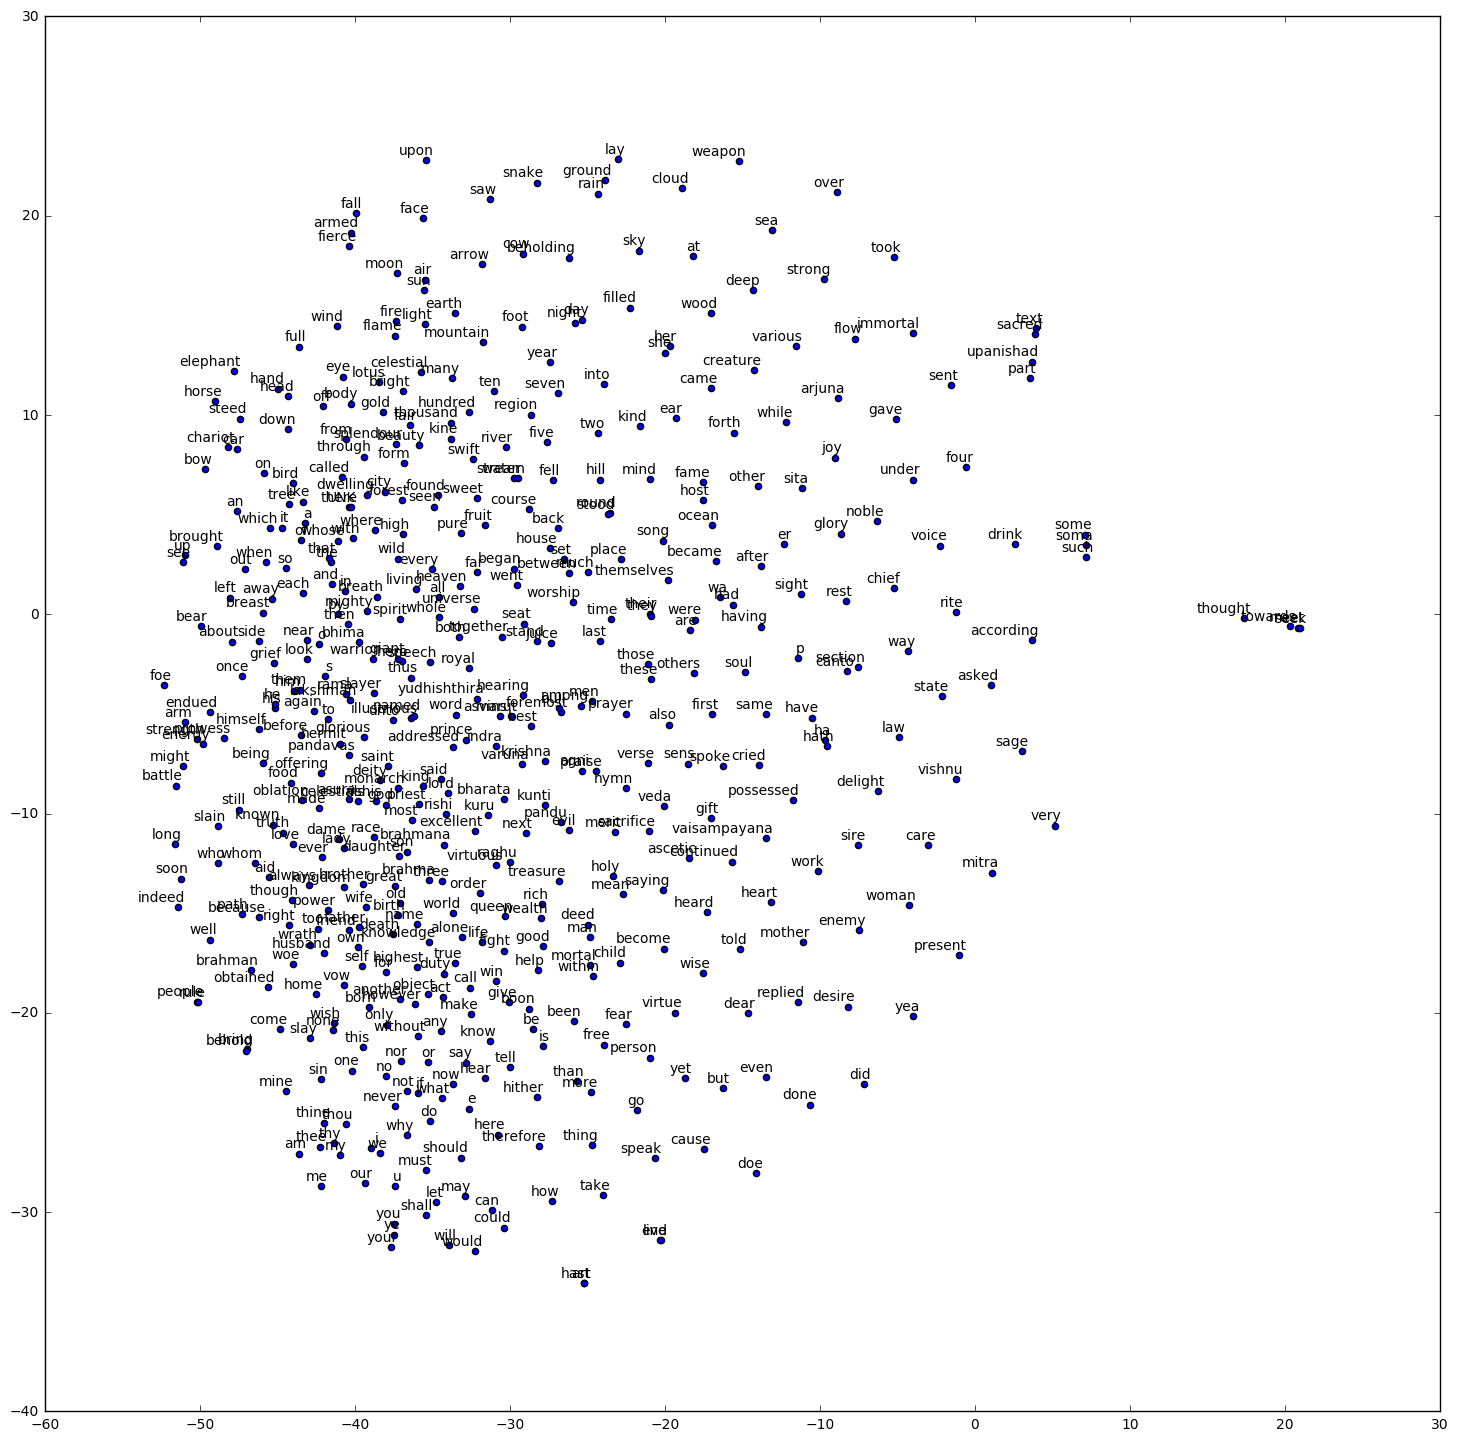

In [15]:
embeddings, dictionary = run_all('hin.zip')
pickle.dump(dictionary, open("hin_dictionary.p", "wb" ))
pickle.dump(embeddings, open("hin_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Judaic texts ##

talmud_jud_token_jud.txt
Raw data length:  220500
ancient_jewish_proverbs_token_jud.txt
Raw data length:  24475
guide_for_the_perplexed_jud_token.txt
Raw data length:  274195
legends_of_the_jews_jud_token.txt
Raw data length:  203123
mishna_jud_token.txt
Raw data length:  162649
old_testament_jud.txt
Raw data length:  610956
Data size 1495898
Vocabulary Size:  11531
Most common words (+UNK) [['UNK', 22883], ('the', 122048), ('and', 64090), ('of', 62310), ('a', 33711)]
Sample data [1, 1942, 702, 2827, 42, 0, 1771, 84, 2750, 11] ['the', 'babylonian', 'talmud', 'tractate', 'b', 'UNK', 'translated', 'into', 'english', 'for']
1771 translated -> 1 the
1771 translated -> 0 UNK
84 into -> 42 b
84 into -> 16 with
2750 english -> 99 time
2750 english -> 2827 tractate
11 for -> 1771 translated
11 for -> 99 time
Initialized
Average loss at step  0 :  244.992767334
Nearest to good: probable, extracted, theirs, jezebel, ahiezer,
Nearest to bad: enumeration, display, pekah, danger, reveal,
Nearest to

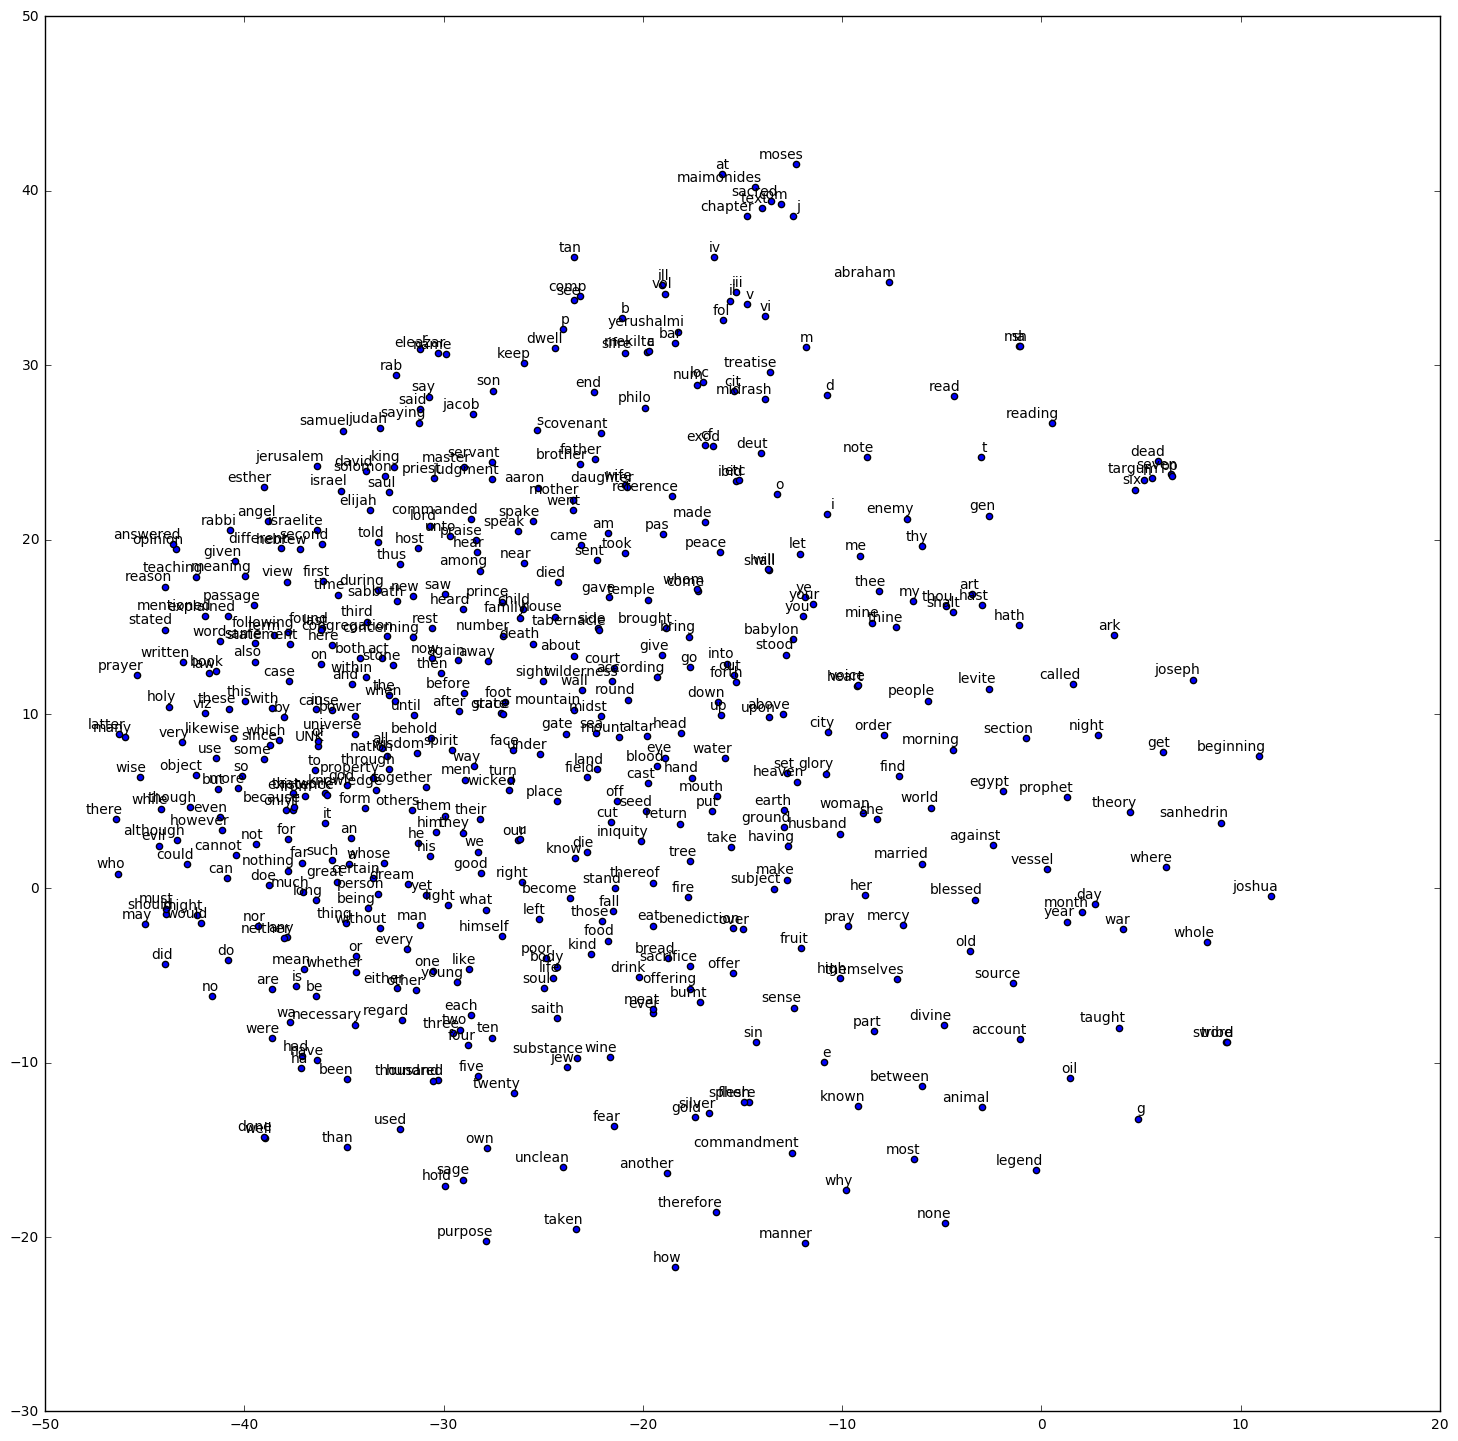

In [16]:
embeddings, dictionary = run_all('jud.zip')
pickle.dump(dictionary, open("jud_dictionary.p", "wb" ))
pickle.dump(embeddings, open("jud_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

## Create & Visualize Word Embeddings from corpus of Muslim texts ##

Sirat_mus_token_mus.txt
Raw data length:  65666
Al Sira al Nabawiyya By Ibn Kathir-All Volumes in One_token_mus.txt
Raw data length:  1000245
quran_token_mus.txt
Raw data length:  425317
rubayyat_mus_token_mus.txt
Raw data length:  3058
SahihMuslimen_mus_token_mus.txt
Raw data length:  725554
Data size 2219840
Vocabulary Size:  13647
Most common words (+UNK) [['UNK', 28527], ('the', 123336), ('of', 81983), ('and', 70180), ('to', 50789)]
Sample data [1503, 2210, 20, 37, 54, 1515, 461, 16, 18, 1] ['sirat', 'rasoul', 'allah', 'by', 'ibn', 'ishag', 'revelation', 'from', 'god', 'the']
461 revelation -> 1 the
461 revelation -> 20 allah
16 from -> 8 him
16 from -> 18 god
18 god -> 461 revelation
18 god -> 0 UNK
1 the -> 6 he
1 the -> 3 and
Initialized
Average loss at step  0 :  240.305633545
Nearest to good: bd, andthe, khidr, shading, conquer,
Nearest to bad: effaced, mounting, striving, ching, compelled,
Nearest to heaven: mahom, neighing, insolent, se, vouchsafed,
Nearest to hell: lifted, 

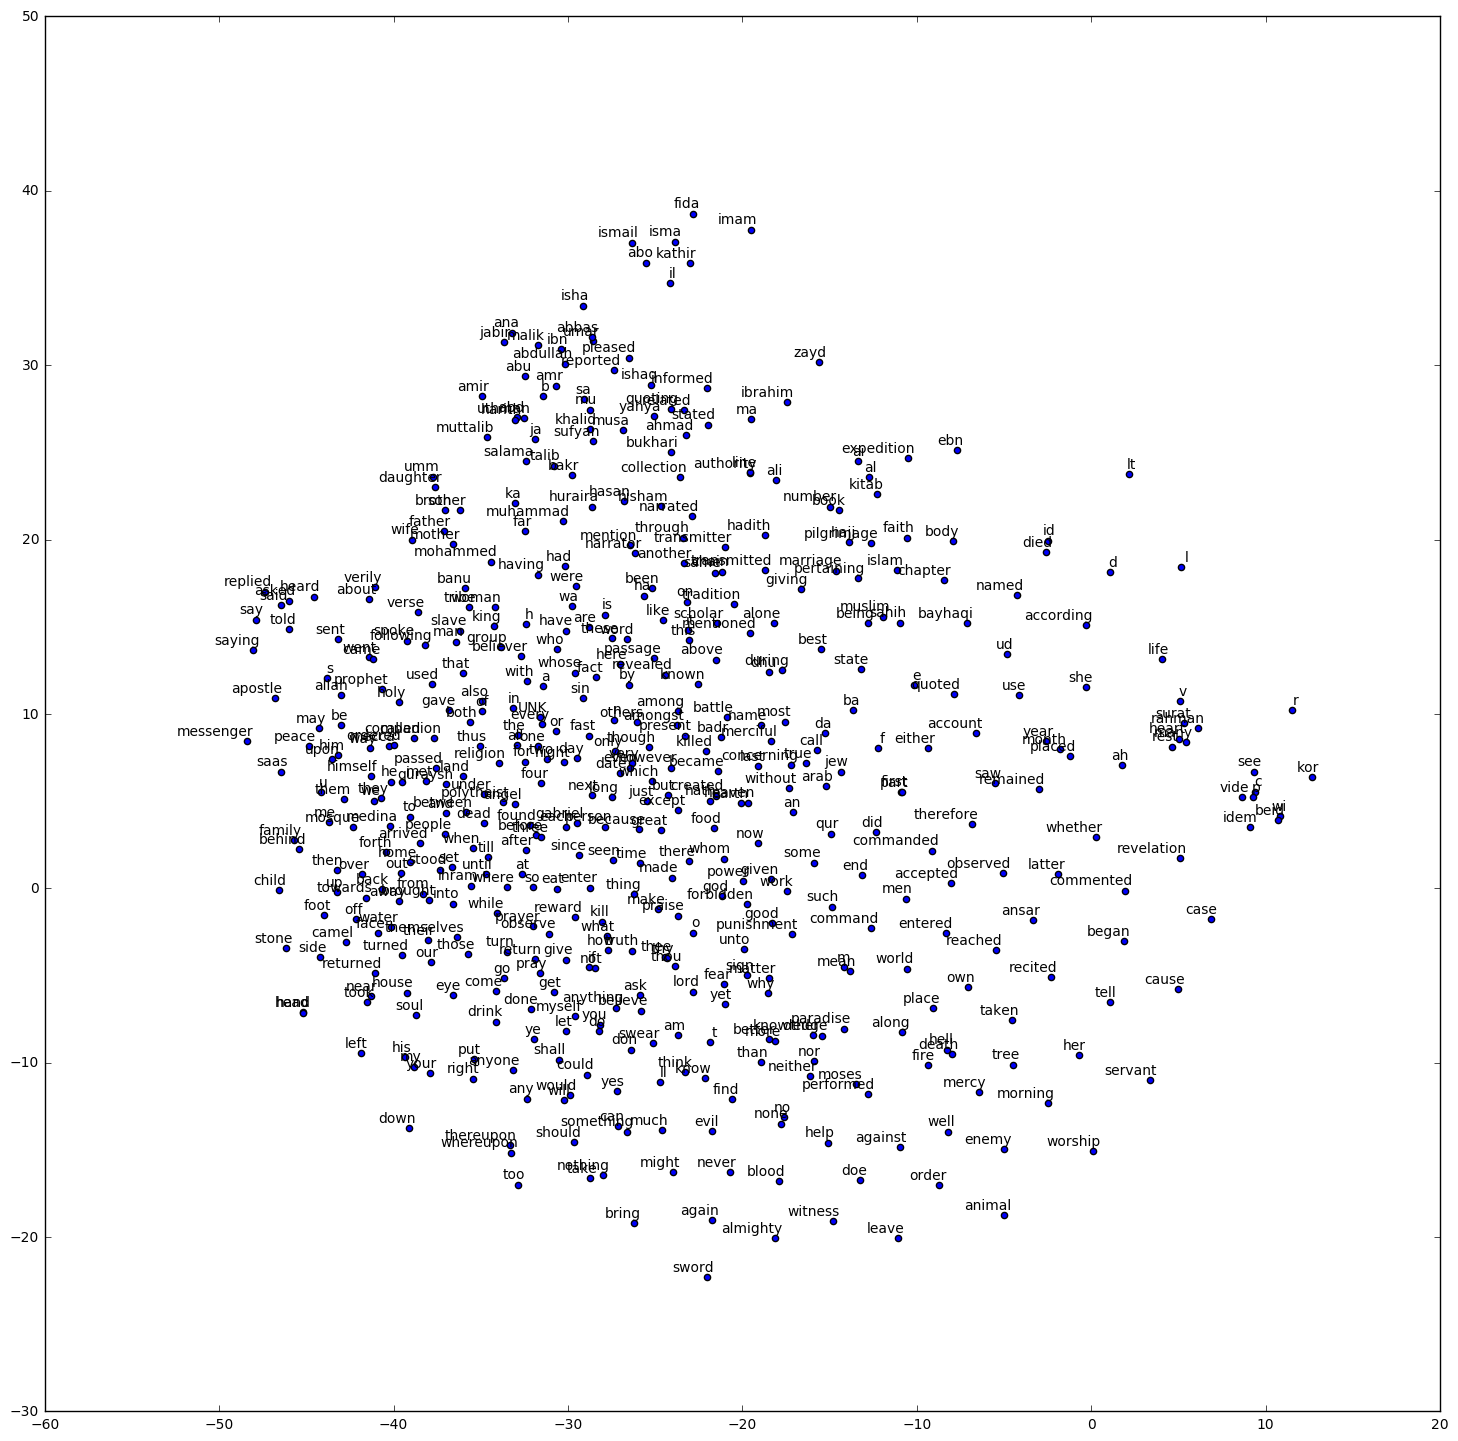

In [17]:
embeddings, dictionary = run_all('mus.zip')
pickle.dump(dictionary, open("mus_dictionary.p", "wb" ))
pickle.dump(embeddings, open("mus_embeddings.p", "wb" ))
del embeddings, dictionary # We don't need them now and need the space

# Create Cosmopolitan Corpus #

## Create Culture Lookup Table##

In [18]:
culture_lookup={\
               '_bud':'Buddhist',\
               '_chi':'Chinese',\
               '_chr':'Christian',\
               '_hin':'Hindu',\
               '_jud':'Judaic',\
               '_mus':'Muslim'
               }
reverse_culture_lookup = {v: k for k, v in culture_lookup.iteritems()}

## Redefine Functions to handle Cosmopolitan Appendings ##

In [19]:
def read_data_cosmo(filename):
  """Extract the files enclosed in a zip file as a list of words"""
  data = []
  with zipfile.ZipFile(filename) as f:
        for current_file in f.namelist():
            print (current_file)
            cur_culture = current_file[-8:-4]
            datanew=tf.compat.as_str(f.read(current_file)).split()
            print ("Raw data length: ", len(datanew))
            datanew_processed = [wnl.lemmatize(x) if x not in word_list else wnl.lemmatize(x)+cur_culture for x in datanew]
            #datanew_processed = [snowball_stemmer.stem(x) for x in datanew]
            data = data + datanew_processed
  return data

In [20]:
def run_word2vec_cosmo(dictionary, reverse_dictionary, batch_size=128,num_skips=2,skip_window=1,embedding_size = 128):
    #valid_examples = [dictionary[snowball_stemmer.stem(x)] for x in word_list]
    #valid_examples = [dictionary[wnl.lemmatize(x)] for x in word_list]
    valid_window = 100
    valid_size = 5
    valid_examples = np.random.choice(valid_window, valid_size, replace=False)
    embedding_dict = load_bin_vec('GoogleNews-vectors-negative300.bin')
    lemma_dict = {}
    import string
    printable = set(string.printable)
    for word in embedding_dict.keys():
        word_stripped = ''.join(filter(lambda x: x in string.printable, word))
        lemma_dict[wnl.lemmatize(word_stripped)] = embedding_dict[word]
    embedding_small_dict = {}
    for word in dictionary.keys():
        if word in lemma_dict.keys():
            embedding_small_dict[word] = lemma_dict[word]
        else:
            embedding_small_dict[word] = np.random.uniform(-1,1,embedding_size)
    embedding = np.array(embedding_small_dict.values())
    embedding_labels = np.array(embedding_small_dict.keys())

    num_sampled = 64    # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default():

      # Input data.
      train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
      train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
      valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Ops and variables pinned to the CPU because of missing GPU implementation
      with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        #embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embeddings = tf.get_variable("embeddings", shape=[len(embedding_small_dict.values()), embedding_size], initializer=tf.constant_initializer(embedding))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

      # Compute the average NCE loss for the batch.
      # tf.nce_loss automatically draws a new sample of the negative labels each
      # time we evaluate the loss.
      loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

      # Construct the SGD optimizer using a learning rate of 1.0.
      optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

      # Compute the cosine similarity between minibatch examples and all embeddings.
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
      similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)

      # Add variable initializer.
      init = tf.global_variables_initializer()

    #Begin training.
    num_steps = 100001
    #num_steps = 1

    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
      init.run()
      print("Initialized")

      average_loss = 0
      for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print("Average loss at step ", step, ": ", average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        #if step % 10000 == 0:
        #  sim = similarity.eval()
        #  for i in xrange(valid_size):
        #    valid_word = reverse_dictionary[valid_examples[i]]
        #    top_k = 8  # number of nearest neighbors
        #    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        #    print (nearest)
        #    log_str = "Nearest to %s:" % valid_word
        #    for k in xrange(top_k):
        #      close_word = reverse_dictionary[nearest[k]]
        #      log_str = "%s %s," % (log_str, close_word)
        #    print(log_str)
      final_embeddings = normalized_embeddings.eval()
    return final_embeddings

In [21]:
def run_all_cosmo(filename):
    stripped_filename = filename[:-4]
    words = read_data_cosmo(filename)
    print('Data size', len(words))
    global vocabulary_size
    vocabulary_size = int(len(set(words))*0.4)
    print('Vocabulary Size: ', vocabulary_size)
    
    global data
    global dictionary

    data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
    del words  # Hint to reduce memory.
    print('Most common words (+UNK)', count[:5])
    print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

    global data_index
    data_index = 0

    batch_size = 128
    embedding_size = 300  # Dimension of the embedding vector.
    skip_window = 6      # How many words to consider left and right.
    num_skips = 2         # How many times to reuse an input to generate a label.


    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    for i in range(8):
      print(batch[i], reverse_dictionary[batch[i]],
            '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

    final_embeddings = run_word2vec_cosmo(dictionary = dictionary, reverse_dictionary = reverse_dictionary,batch_size=batch_size,num_skips=num_skips,skip_window=skip_window,embedding_size = embedding_size)

    try:
      tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
      plot_only = 500
      low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
      labels = [reverse_dictionary[i] for i in xrange(plot_only)]
      plot_with_labels(low_dim_embs, labels,stripped_filename)
      plt.show()

    except ImportError:
        print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")
    
    return final_embeddings

## Create Cosmopolitan Embeddings ##

Vishnupurana_hin_token_hin.txt
Raw data length:  154825
writings_of_francis_of_assisi_token_chr.txt
Raw data length:  54212
95_theses_token_chr.txt
Raw data length:  4528
Al Sira al Nabawiyya By Ibn Kathir-All Volumes in One_token_mus.txt
Raw data length:  1000245
amitabha_token_bud.txt
Raw data length:  20807
ancient_jewish_proverbs_token_jud.txt
Raw data length:  24475
art_of_war_chi_token_chi.txt
Raw data length:  57591
bhagavad_gita_token_hin.txt
Raw data length:  20763
bible_token_chr.txt
Raw data length:  791844
book_of_poetry_chi_token.txt
Raw data length:  77547
chinese_buddhism_chi_token.txt
Raw data length:  163782
chinese_buddhism_token_chi.txt
Raw data length:  163782
confession_of_st_augustine_token_chr.txt
Raw data length:  112466
Confucius - Analects_token_chi.txt
Raw data length:  28097
Confucius - The Doctorine of the Mean_token_chi.txt
Raw data length:  6711
Confucius - The Great Learning_token_chi.txt
Raw data length:  3085
dao_de_jing_token_chi.txt
Raw data length: 

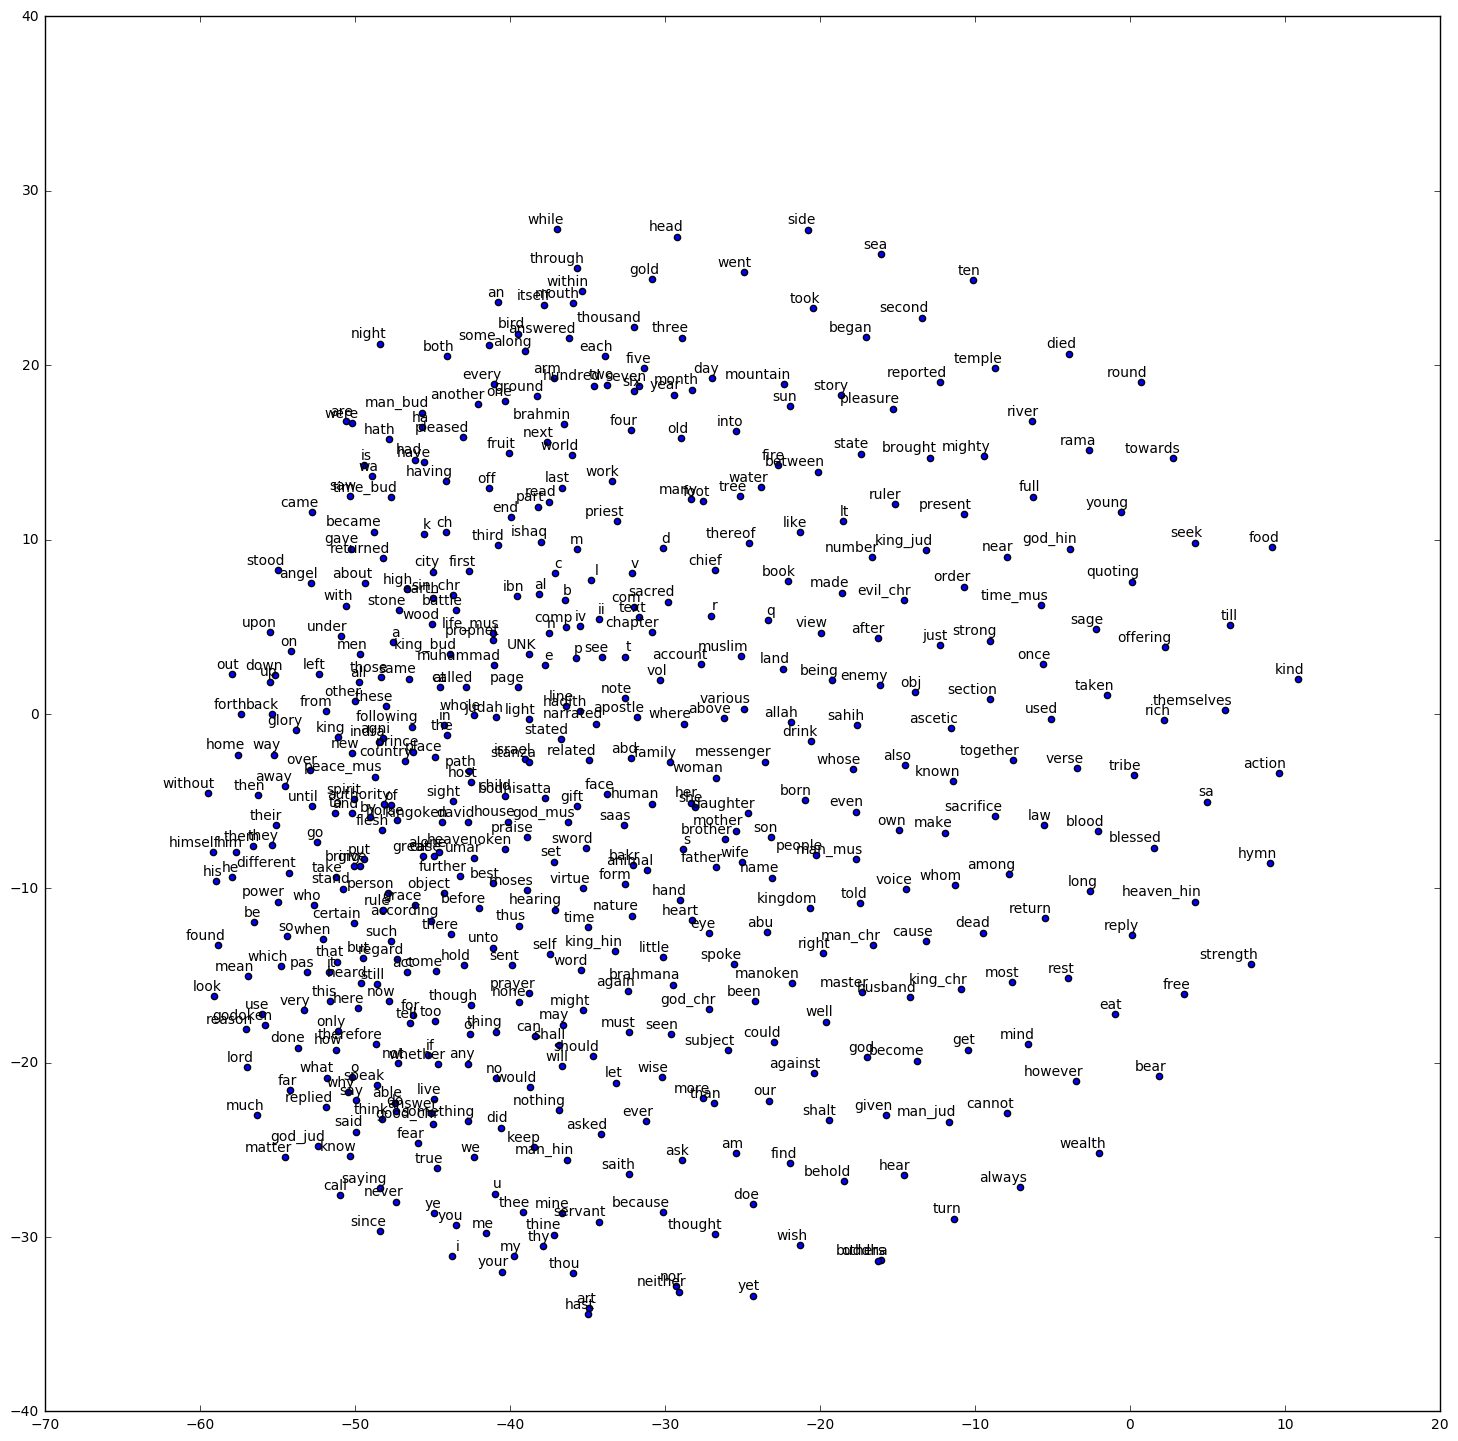

In [22]:
cosmo_embeddings = run_all_cosmo('token_tag.zip')

In [23]:
pickle.dump(dictionary, open("cosmo_dictionary.p", "wb" ))
pickle.dump(cosmo_embeddings, open("cosmo_embeddings.p", "wb" ))

In [24]:
dictionary = pickle.load(open("cosmo_dictionary.p", "rb" ))
cosmo_embeddings = pickle.load(open("cosmo_embeddings.p", "rb" ))

## Produce Similarity Matricies & Cross-Cultural Nearest Neighbors ##

In [25]:
totals = pd.DataFrame(columns = ['score'],index = word_list)
cultures = culture_lookup.keys()
top_similarity_matrix = np.zeros([len(culture_lookup),len(culture_lookup)])
word_dataframe = pd.DataFrame(columns=[culture_lookup[culture] for culture in cultures],index=[culture_lookup[culture] for culture in cultures])
for word in word_list:
    similarity_matrix = np.zeros([len(culture_lookup),len(culture_lookup)])
    word_identifier = "\nSimilarity Matrix for %s" % word
    print (word_identifier)
    for y_culture_num in range(len(cultures)):
        y_entry_num = dictionary.get(word+cultures[y_culture_num],np.nan)
        for x_culture_num in range(len(cultures)):
            x_entry_num = dictionary.get(word+cultures[x_culture_num],np.nan)
            if np.any([np.isnan(y_entry_num), np.isnan(x_entry_num)]):
                similarity_matrix[y_culture_num,x_culture_num] = np.nan
            else:
                y_embedding = cosmo_embeddings[y_entry_num,:].reshape(1,-1)
                x_embedding = cosmo_embeddings[x_entry_num,:].reshape(1,-1)
                similarity = cosine_similarity(y_embedding,x_embedding)
                similarity_matrix[y_culture_num,x_culture_num] = similarity
                if similarity > top_similarity_matrix[y_culture_num,x_culture_num]:
                    top_similarity_matrix[y_culture_num,x_culture_num] = similarity
                    word_dataframe.iloc[y_culture_num,x_culture_num] = word
    similarity_dataframe = pd.DataFrame(data = similarity_matrix,columns=[culture_lookup[culture] for culture in cultures],index=[culture_lookup[culture] for culture in cultures])
    print (similarity_dataframe)
    totals.ix[word]['score'] = similarity_dataframe.values.sum()
for culture_num in range(len(cultures)):
    word_dataframe.iloc[culture_num,culture_num] = 'N/A'
print ("\nMost Similar Word Matrix:")
print (word_dataframe)


Similarity Matrix for good
           Christian     Hindu    Judaic    Muslim  Buddhist   Chinese
Christian   1.000000  0.432184  0.501521  0.543416  0.239851  0.227424
Hindu       0.432184  1.000000  0.339626  0.523304  0.273970  0.173474
Judaic      0.501521  0.339626  1.000000  0.372582  0.127928  0.145452
Muslim      0.543416  0.523304  0.372582  1.000000  0.219095  0.232863
Buddhist    0.239851  0.273970  0.127928  0.219095  1.000000  0.074361
Chinese     0.227424  0.173474  0.145452  0.232863  0.074361  1.000000

Similarity Matrix for bad
           Christian     Hindu    Judaic    Muslim  Buddhist   Chinese
Christian   1.000000  0.215298  0.191613  0.160816  0.097592  0.046248
Hindu       0.215298  1.000000  0.637172  0.265519  0.232737  0.247051
Judaic      0.191613  0.637172  1.000000  0.175558  0.302413  0.176015
Muslim      0.160816  0.265519  0.175558  1.000000  0.107603  0.190585
Buddhist    0.097592  0.232737  0.302413  0.107603  1.000000  0.087628
Chinese     0.046248  

In [26]:
distance_dataframe = pd.DataFrame(columns = ['score'],index = word_list)
cultures = culture_lookup.keys()
top_similarity_matrix = np.zeros([len(culture_lookup),len(culture_lookup)])
word_dataframe = pd.DataFrame(columns=[culture_lookup[culture] for culture in cultures],index=[culture_lookup[culture] for culture in cultures])
for word in word_list:
    culture_words = [word+culture for culture in culture_lookup.keys()]
    word_matrix = np.concatenate([cosmo_embeddings[dictionary.get(culture_word,np.nan),:].reshape(300,1) for culture_word in culture_words], axis = 1)
    centroid = np.mean(word_matrix, axis = 1)
    distances = []
    for culture_num in range(word_matrix.shape[1]):
        distances.append(np.linalg.norm(np.subtract(word_matrix[:,culture_num],centroid)))
    distance_dataframe.ix[word]['score'] = sum( distances)
distance_dataframe.sort_values('score',ascending = True, inplace = True)
print (distance_dataframe)

              score
soul        3.32634
knowledge   3.70695
destroy     3.75873
worship     3.87242
friendship  3.96047
love        4.16998
suffering   4.18667
happy       4.35235
pray        4.39796
time        4.42432
child       4.42812
friend      4.46673
happiness   4.47511
joy         4.50187
war         4.50565
life        4.52424
salvation    4.5436
good        4.56409
desire      4.58645
wisdom       4.6269
eternal     4.63387
mercy       4.64107
god         4.66025
hate        4.66549
holy        4.66728
body        4.67649
hell        4.67949
rejoice      4.6876
evil        4.71572
sin         4.72737
heaven      4.80191
man         4.80509
truth       4.80877
bad         4.85019
birth       4.88922
suffer      4.94934
death       4.96829
faith       4.99896
justice     5.03172
peace       5.06368
king        5.08015
